In [1]:
import tensorflow as tf

In [2]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [69]:
import src.data_prep as dp
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
import plotly.graph_objects as go
import nltk
from nltk.corpus import stopwords
from os import path
from PIL import Image

%config InlineBackend.figure_format = 'retina'

In [2]:
plt.style.use("cyberpunk")
# plt.style.use('fivethirtyeight')
# plt.style.use('dark_background')
# plt.style.use('seaborn-bright')

In [3]:
reports = dp.import_data("data/data.json")
df = dp.create_df(reports)
df = df.reset_index()
df = df.rename(columns={"index": "id"})
df.head()

,id,YEAR,SEASON,MONTH,STATE,COUNTY,LOCATION DETAILS,NEAREST TOWN,NEAREST ROAD,OBSERVED,ALSO NOTICED,OTHER WITNESSES,OTHER STORIES,TIME AND CONDITIONS,ENVIRONMENT,DATE
0,60,1994-1997+,Spring,NaN,Washington,Skagit County,"Up the Baker hwy., about 12 miles north from H...",Concrete,Mt.Baker Hwy,"These two gentlmen, brothers, recluses age 50'...",Feces was found and sent to a University in Mo...,NaN,There is a ridge along their property-Doc Butt...,These events occured from May all thru June an...,200 acres of interspersed Old growth Douglas Fir.,intermittant
1,70,2000,Summer,July,New York,Washington County,1/2 mile into the trail to Buck Mountain,Queensbury,Shelving Rock Road,My wife and I were off the trail to take some ...,NaN,My wife,The local Police chased a Bigfoot into the woo...,"2 pm , partly cloudy with light rain",Next to a creek 300 feet off the trail to Buck...,9
2,76,1997,Summer,June,Arkansas,Baxter County,THE LOCATION WAS IN THE GOVERNMENT TRACK LAND ...,Mt. Home,101 bridge,I DID NOT SEE ANYTHING. I DID HEAR A LOT. WH...,LOUD SHRILL,THRE TOTAL/FISHING,NO.,THIS INCIDENT DID TAKE PLACE ON THE EARLY MORN...,THE AREA IS A DENSE FOREST WHICH SURROUNDS A V...,25-27approx
3,77,1983,Fall,September,Washington,Kittitas County,"I haven't been there in years, but an area map...",Yakima,Chinook pass hyway 410,"We had driven into Milk pond, up Chinook pass,...","we thought it was weird the frogs stopped, usa...","my husband, Glenn. we had a tape recorded, bu...",NaN,NaN,"pine forest, you have to drive up to get to th...",?
4,80,1983,Summer,August,Oregon,Lane County,"It was at Kitson Springs, near the Willamette ...","Bend, Oregon",State Hwy 58,"My veterinarian sister, former girlfriend, and...",NaN,3 persons total. We were tring to get some sl...,On another occaison I had found and photograhe...,"1:00AM dark, warm evening. clear sky.","Forest, mountains and streams",12


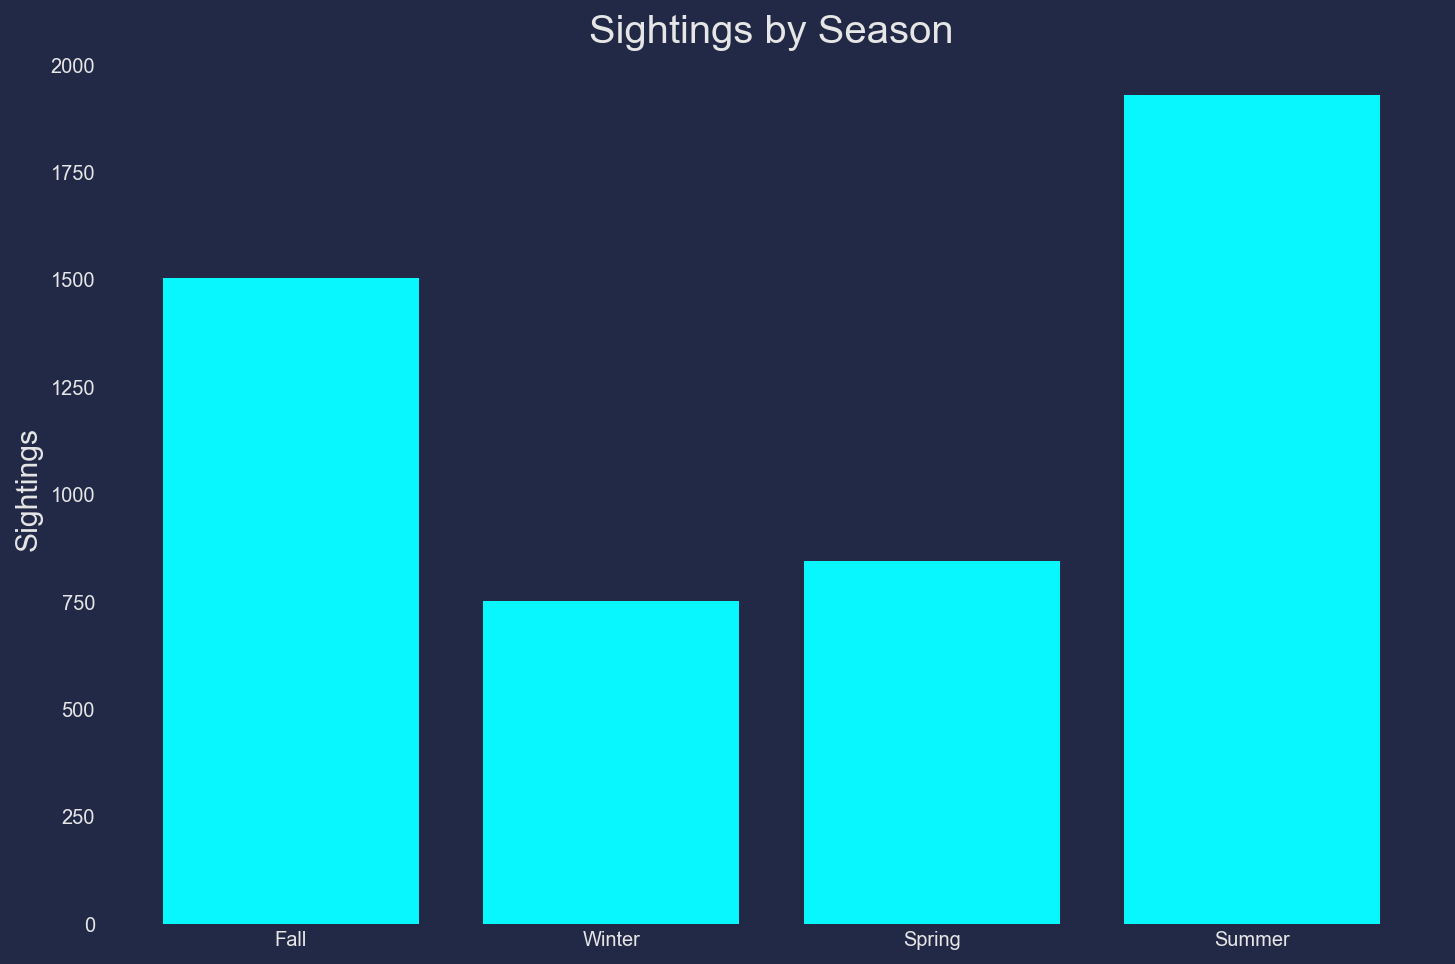

In [16]:
seasons = df.groupby('SEASON').count()['id']

fig, ax = plt.subplots(figsize=(12,8))
s = ['Fall','Winter','Spring','Summer']
ax.bar(s, seasons[s])
ax.set_title('Sightings by Season', fontsize=20)
ax.set_ylabel('Sightings', fontsize=15)
ax.grid(False)
plt.savefig('images/sightings_by_season1.png')
plt.show()

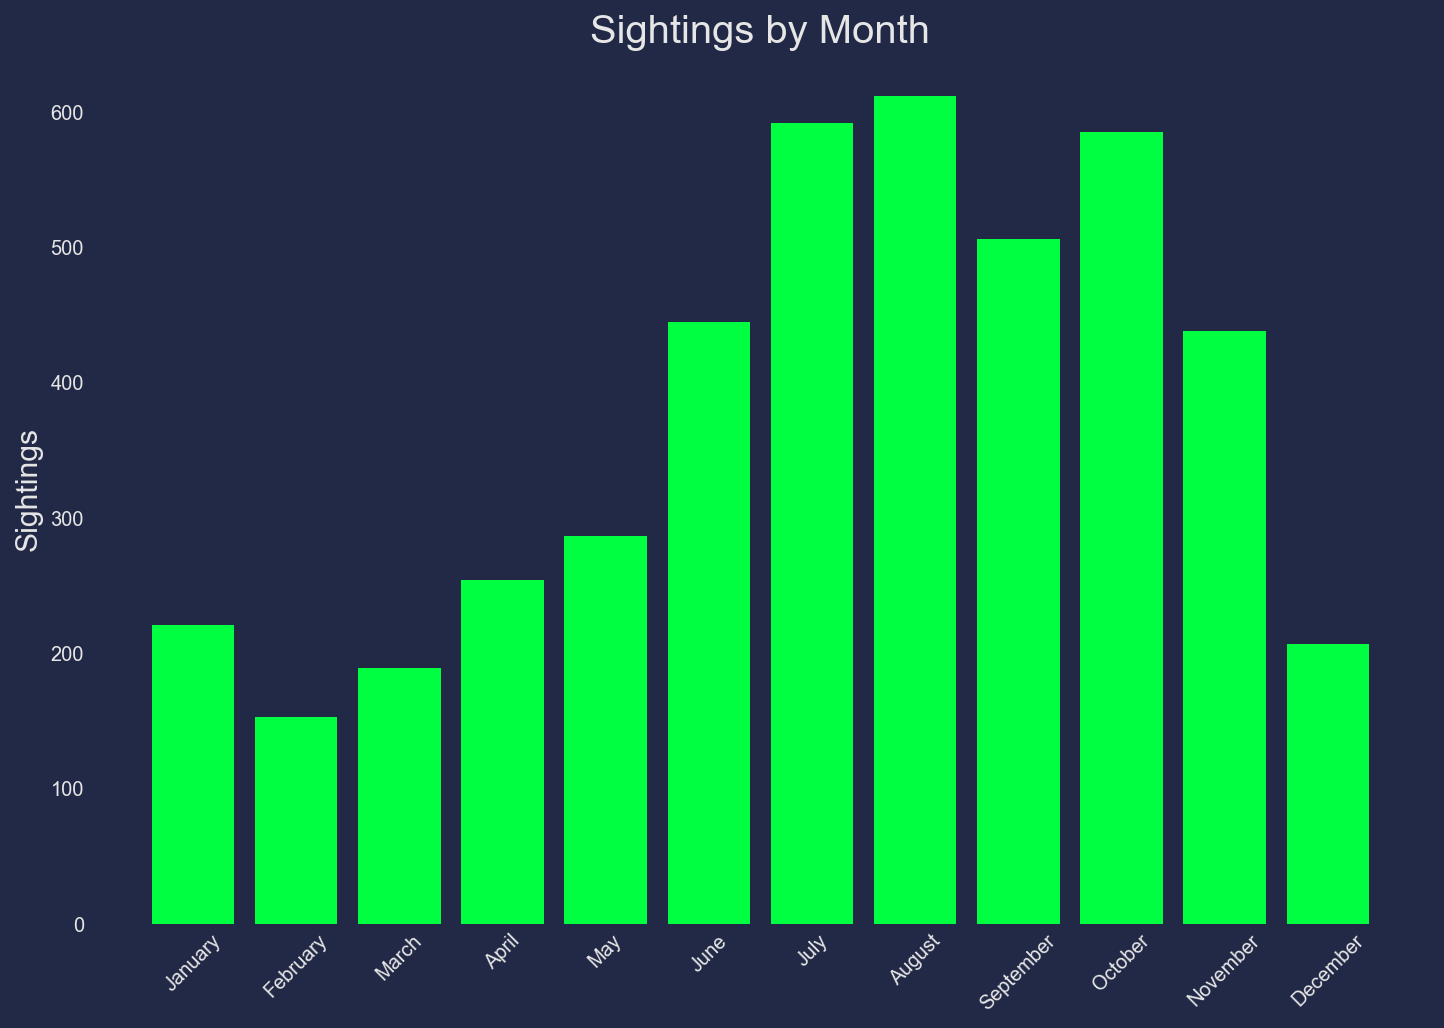

In [17]:
months = df.groupby('MONTH').count()['id']
fig, ax = plt.subplots(figsize=(12,8))
m = ['January','February','March','April','May','June','July','August','September','October','November','December']
ax.bar(m, months[m], color = '#00ff41')
ax.set_title('Sightings by Month', fontsize=20)
ax.set_ylabel('Sightings', fontsize=15)
ax.set_xticklabels(m, rotation=45)
ax.grid(False)
fig.savefig('images/month_bar_er.png')

In [8]:
def tryconvert(x):
    try:
        x = int(str(x[:4]))
    except:
        x = np.nan
    if x > 1000:
        return x
    else:
        return np.nan

df['YEAR'] = df['YEAR'].apply(lambda x: tryconvert(x))

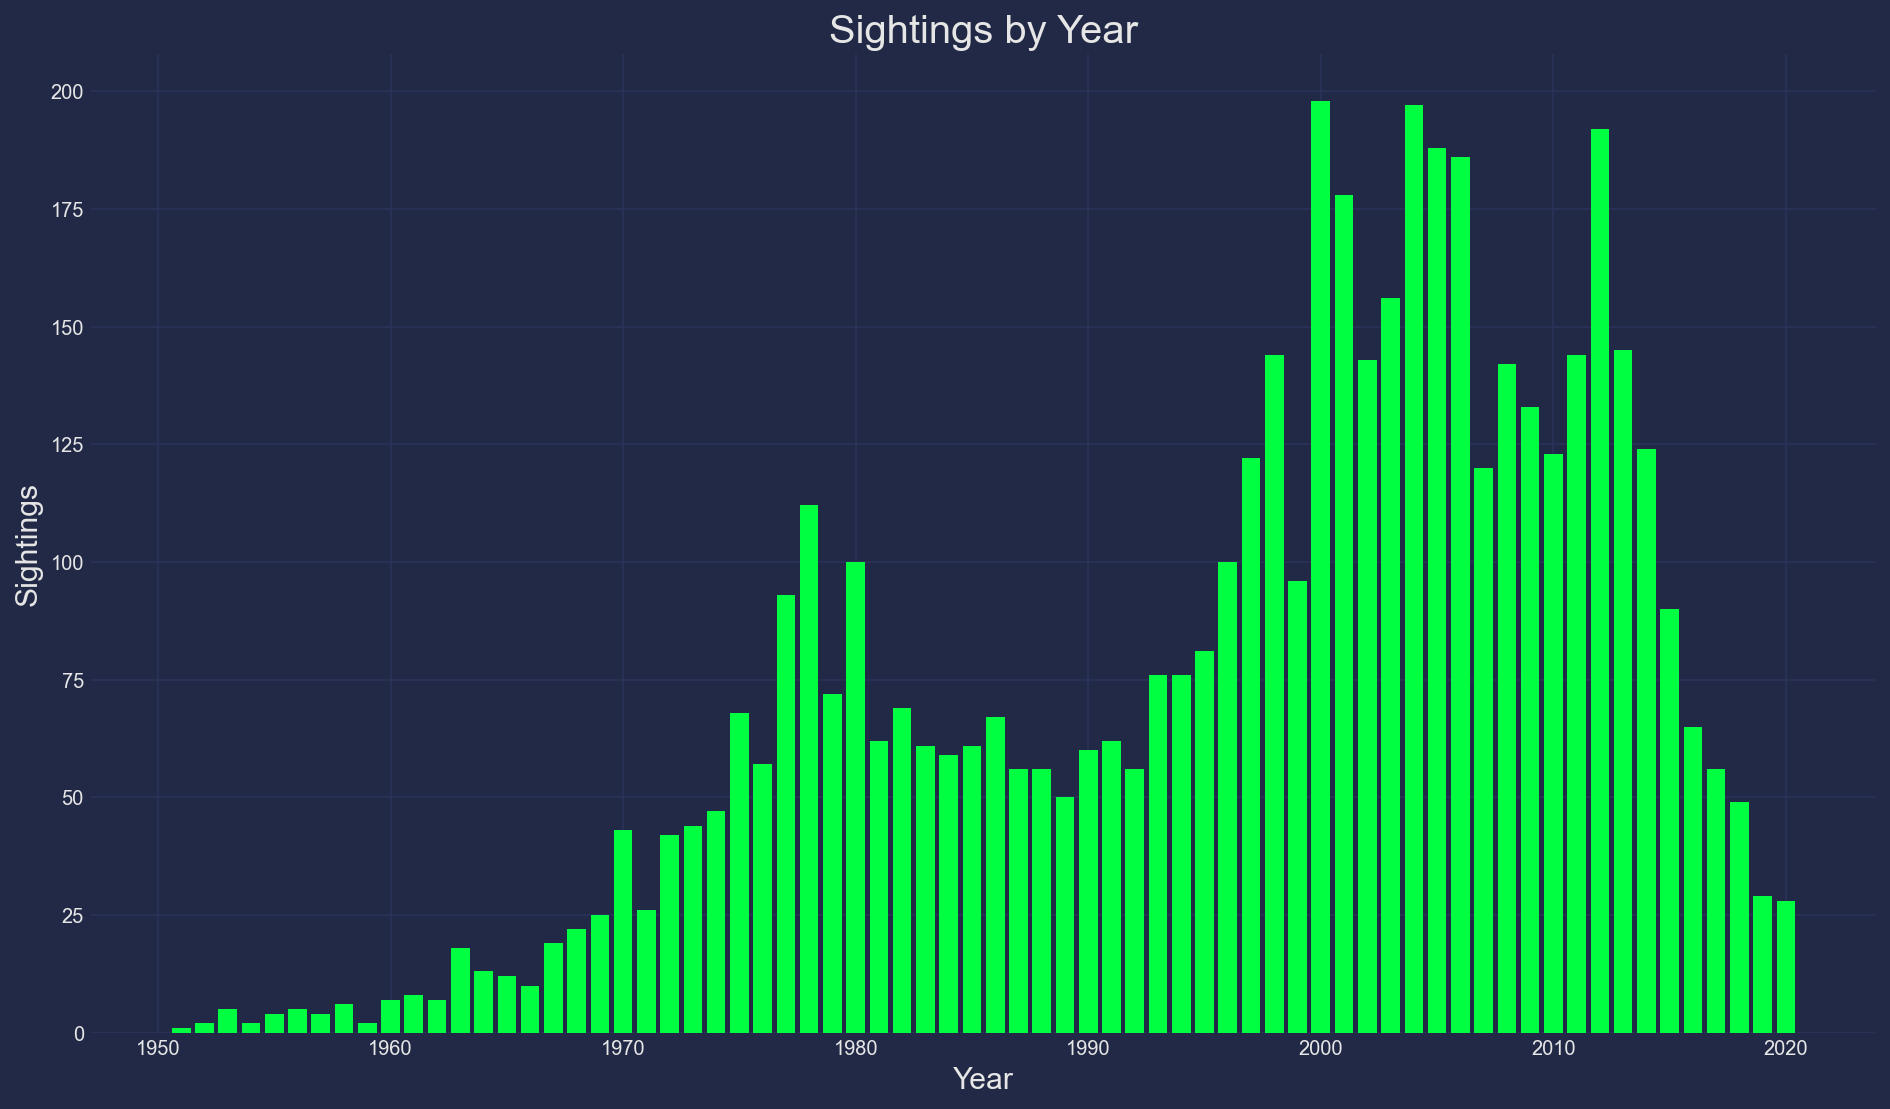

In [15]:
year = df.groupby('YEAR').count()['id']
year = year[year.index > 1950]
fig, ax = plt.subplots(figsize=(16,9))
ax.bar(year.index, year.values, color = '#00ff41')
ax.set_title('Sightings by Year', fontsize=20)
ax.set_ylabel('Sightings', fontsize=15)
ax.set_xlabel('Year', fontsize=15)
# fig.savefig('../images/year_bar_er.png')
plt.show()

## NLP

In [6]:
observed_df = df.loc[df['OBSERVED'].notnull()]

In [7]:
cv = CountVectorizer()
cv_fit = cv.fit_transform(observed_df['OBSERVED'])

In [8]:
vocab_cv = cv.get_feature_names()
vocab_count = cv_fit.toarray().sum(axis=0)

In [9]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(observed_df['OBSERVED'])
vocab = np.array(sorted(tfidf.vocabulary_))
V = tfidf_matrix

In [10]:
cluster = KMeans(n_clusters=6)
cluster.fit(tfidf_matrix)
centroids = cluster.cluster_centers_

In [11]:
for idx, topic in enumerate(centroids):
    print(vocab[np.argsort(-topic)[:10]])

['heard' 'sound' 'like' 'tent' 'night' 'loud' 'sounded' 'sounds' 'camp'
 'scream']
['tracks' 'prints' 'print' 'snow' 'foot' 'inches' 'track' 'trail' 'toes'
 'footprints']
['just' 'saw' 'like' 'tree' 'woods' 'looked' 'trail' 'deer' 'got' 'feet']
['road' 'saw' 'car' 'driving' 'creature' 'tall' 'just' 'looked' 'hair'
 'like']
['creature' 'saw' 'area' 'large' 'river' 'seen' 'like' 'tall' 'feet'
 'bigfoot']
['house' 'window' 'door' 'heard' 'dogs' 'outside' 'like' 'dog' 'night'
 'went']


In [12]:
labels = np.array(['Heard', 'Tracking' 'Seen', 'Driving', 'Saw', 'House'])

In [13]:
report_label = labels[np.argmin(cluster.transform(tfidf_matrix), axis=1)]

IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
observed_df['label_clustering'] = report_label

In [ ]:
nmf = NMF(n_components=6)
nmf.fit(V)
W = nmf.transform(V)
H = nmf.components_

In [ ]:
for idx, topic in enumerate(H):
    print(vocab[np.argsort(-topic)[:15]])

In [ ]:
labels = np.array(['Witnessed','Heard','Found Tracks','Saw from House','While Driving','While Camping'])

In [ ]:
report_label = labels[np.argmax(W, axis=1)]

In [ ]:
observed_df['label_NMF'] = report_label

In [ ]:
nmf.reconstruction_err_

In [ ]:
observed_df.to_csv('data/nlp_observed_df.csv')

In [ ]:
observed_df = pd.read_csv('data/nlp_observed_df.csv')

## Word Cloud

In [ ]:
dp.get_bag_of_words(df, ['OBSERVED', 'ALSO NOTICED', 'OTHER STORIES', 'ENVIRONMENT', 'TIME AND CONDITIONS', 'LOCATION DETAILS'], 'data', 'bagofwords')

In [9]:
with open('data/bagofwords.txt', "r", encoding='utf-8') as f:
    data = f.read()

In [13]:
print('character length of bag of words: ', len(data))

character length of bag of words:  12637223


In [20]:
print(data[:300])

These two gentlmen, brothers, recluses age 50's phoned me and explained these events. They own and operate a cattle ranch. They have over 200 acres of interspersed Old growth Douglas Fir and graze. There is virtually no access (by vehicle) to their land, because of swamps, creeks and no roads, excep


In [65]:
s = data
s = s.replace('  ', ' ').split(' ')
bow = []
for j in s:
    k = ''.join([i for i in j if i.isalpha()])
    if len(k) > 1:
        bow.append(k)

In [67]:
bow[:25]

['These',
 'two',
 'gentlmen',
 'brothers',
 'recluses',
 'age',
 'phoned',
 'me',
 'and',
 'explained',
 'these',
 'events',
 'They',
 'own',
 'and',
 'operate',
 'cattle',
 'ranch',
 'They',
 'have',
 'over',
 'acres',
 'of',
 'interspersed',
 'Old']

In [78]:
def remove_stopwords(word_list, stop_words):
    """input: a list of words
       output: a list of words with stop_words removed"""
    valids = []
    for word in word_list:
        if word not in stop_words:
            valids.append(word)
    return ' '.join(valids)


In [74]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [75]:
stop_words = set(stopwords.words('english'))

In [79]:
t = remove_stopwords(bow, stop_words)


In [70]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 1.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

In [81]:
bigfoot_mask = np.array(Image.open("images/bigfoot-outline.jpg"))

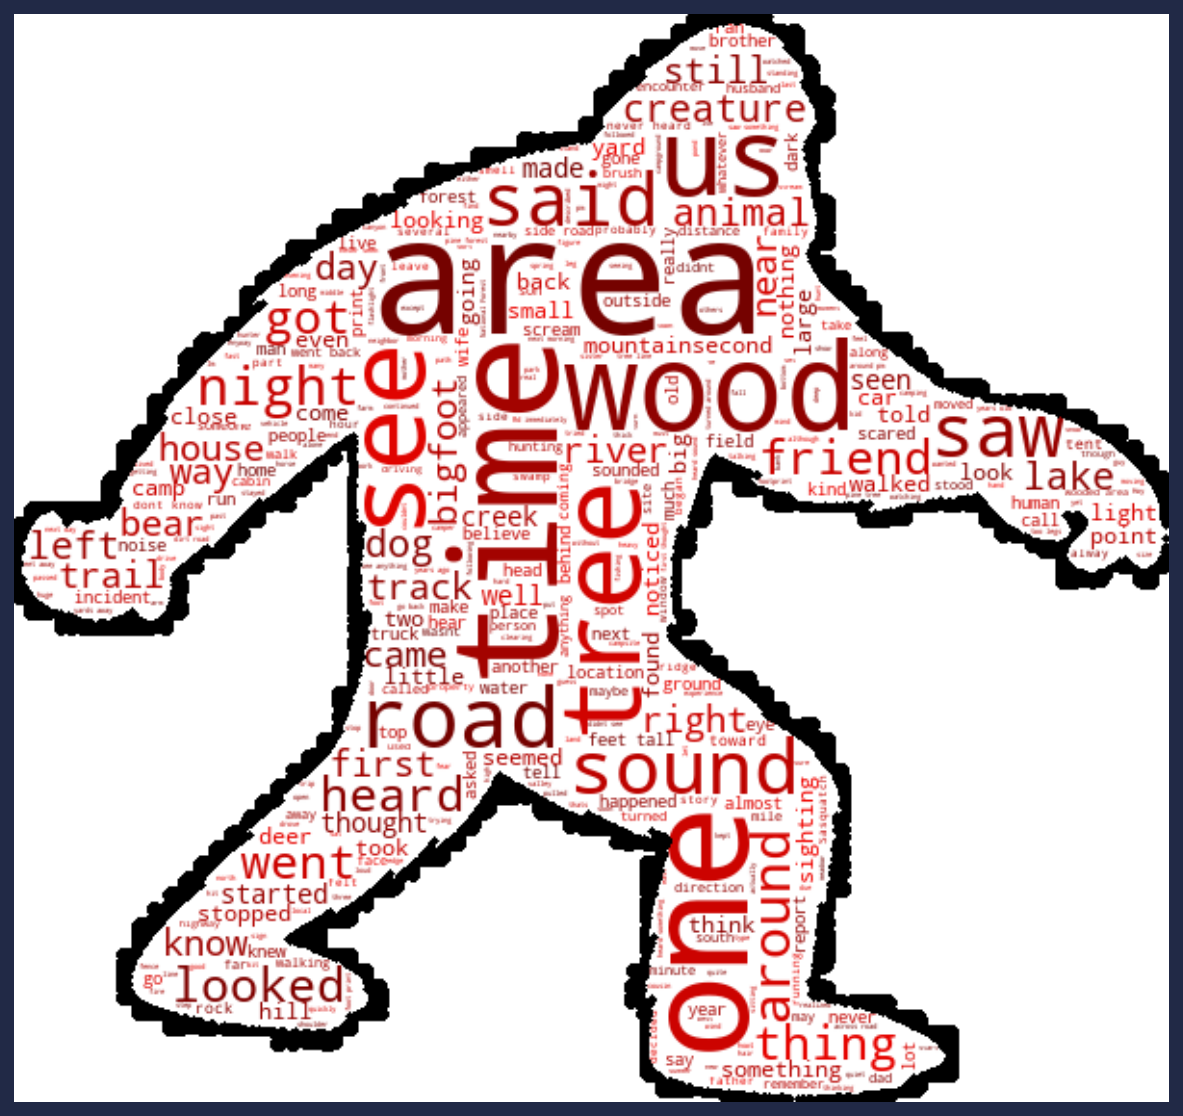

In [82]:
wc = WordCloud(background_color="white", max_words=1000, mask=bigfoot_mask,
               contour_width=6, contour_color='black', color_func=random_color_func)

# Generate a wordcloud
wc.generate(t)

# store to file
wc.to_file("images/bigfoot_words.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()